# Exploration exercises

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from prepare import basic_clean, lemmatize, remove_stopwords, tokenize
import acquire
import seaborn as sns
from wordcloud import WordCloud
import prepare

## Spam Data

### Load the spam data set.

In [2]:
df = pd.read_csv('spam_clean.csv')
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Cleaning the text data

In [3]:
def clean(string):
    new_string = lemmatize(remove_stopwords(basic_clean(string), extra_words=['r', 'u', '2', 'ltgt',  "'", "''"]))
    return new_string

In [4]:
df.text = df.text.apply(clean)

### Checking proportions of ham and spam

In [5]:
labels = pd.concat([df.label.value_counts(), df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


### Creating variables that will hold strings of the data.

In [6]:
all_text_string = ' '.join(df.text)
ham_string = ' '.join(df[df.label == 'ham'].text)
spam_string = ' '.join(df[df.label == 'spam'].text)

### Using those variables to create a series for each and looking at the word counts

In [7]:
all_counts = pd.Series(all_text_string.split()).value_counts()
all_counts.head()

call    600
get     397
ur      384
i'm     380
go      304
dtype: int64

In [8]:
ham_counts = pd.Series(ham_string.split()).value_counts()
ham_counts.head()

i'm     372
get     314
go      273
ok      267
come    242
dtype: int64

In [9]:
spam_counts = pd.Series(spam_string.split()).value_counts()
spam_counts.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

### Using those series to make a dataframe of the word counts

In [10]:
word_counts = pd.concat([all_counts, ham_counts, spam_counts], axis=1)
word_counts.rename(columns={0:'all', 1:'ham', 2:'spam'}, inplace=True)
word_counts = word_counts.fillna(0)
word_counts = word_counts.apply(lambda x: x.astype('int'))
word_counts.sort_values(by='all', ascending=False).head()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,all,ham,spam
call,600,241,359
get,397,314,83
ur,384,240,144
i'm,380,372,8
go,304,273,31


### Words that are frequent and distinct to ham or spam.

In [11]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
i'll,167,167,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


### Visualizing the proportion of ham vs spam for the most common words.

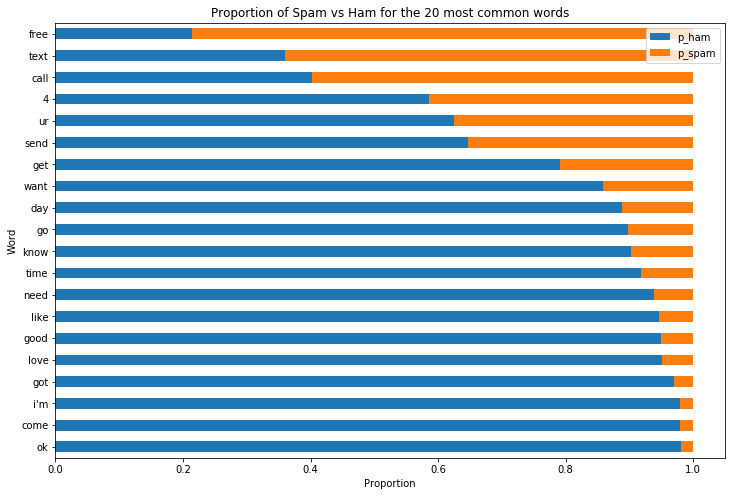

In [12]:
word_counts.assign(p_ham=word_counts.ham/word_counts['all'],
                   p_spam=word_counts.spam/word_counts['all']).\
    sort_values(by='all').\
    tail(20)\
    [['p_ham', 'p_spam']].\
    sort_values(by='p_spam')\
    .plot.barh(stacked=True, figsize=(12, 8))
plt.title('Proportion of Spam vs Ham for the 20 most common words')
plt.xlabel('Proportion')
plt.ylabel('Word')
plt.show()

### Looking at the ratio of spam to ham for each word
Helps determine which words occur more often in ham and more often in spam.

In [13]:
word_counts[(word_counts.spam > 10) & (word_counts.ham > 10)].\
assign(ratio=lambda df: df.spam / df.ham).\
sort_values(by='ratio').\
pipe(lambda df: pd.concat([df.head(), df.tail()]))

,all,ham,spam,ratio
good,235,223,12,0.053812
like,245,232,13,0.056034
need,181,170,11,0.064706
dont,140,129,11,0.085271
time,232,213,19,0.089202
contact,70,14,56,4.000000
win,76,15,61,4.066667
cash,74,12,62,5.166667
mobile,150,15,135,9.000000
txt,163,13,150,11.538462


### WordCloud

In [32]:
type(ham_string)

str

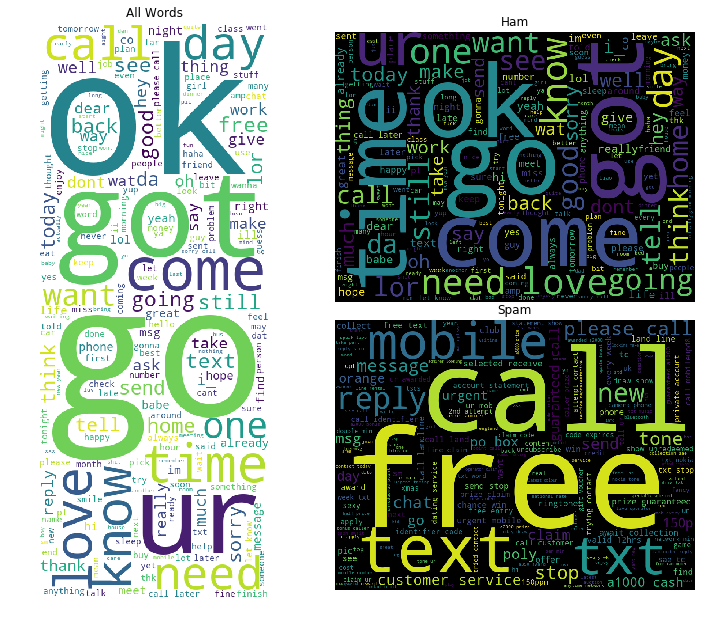

In [14]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(all_text_string)
ham_cloud = WordCloud(background_color='black', height=600, width=800).generate(ham_string)
spam_cloud = WordCloud(background_color='black', height=600, width=800).generate(spam_string)

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

### Create and explore bigrams for the spam data. 
Visualize them with a word cloud. How do they compare with the ham bigrams?

In [15]:
top_20_ham_bigrams = pd.Series(nltk.ngrams(ham_string.split(), 2)).value_counts().head(20)
top_20_ham_bigrams.head()

(call, later)      52
(i'll, call)       44
(let, know)        42
(sorry, i'll)      39
(good, morning)    31
dtype: int64

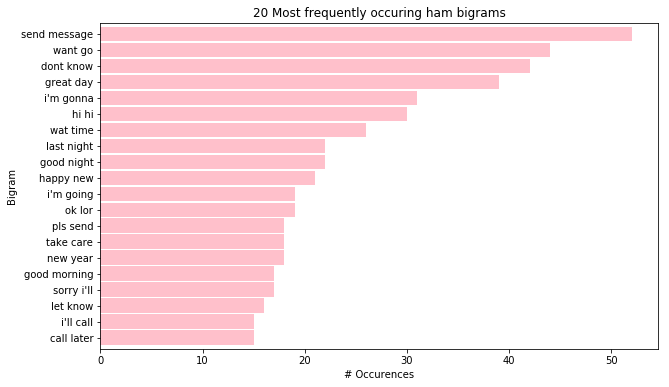

In [16]:
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


(-0.5, 799.5, 399.5, -0.5)

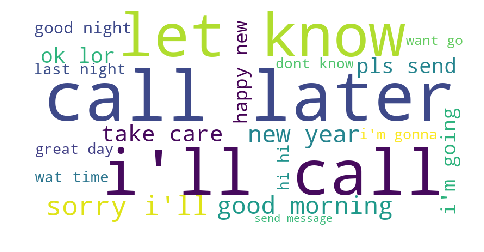

In [17]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

### Is there any overlap in the bigrams for the spam data and the ham data?

In [18]:
top_20_spam_bigrams = pd.Series(nltk.ngrams(spam_string.split(), 2)).value_counts().head(20)
top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(guaranteed, call)     23
(a1000, cash)          23
dtype: int64

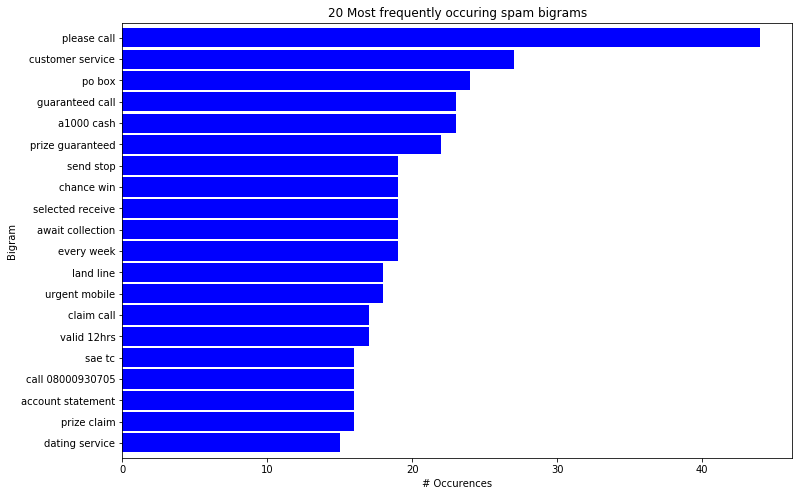

In [19]:
top_20_spam_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurences')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index().sort_values(by=0)['index'].apply(lambda t: t[0] + ' ' + t[1])
plt.yticks(ticks, labels)
plt.show()

(-0.5, 799.5, 799.5, -0.5)

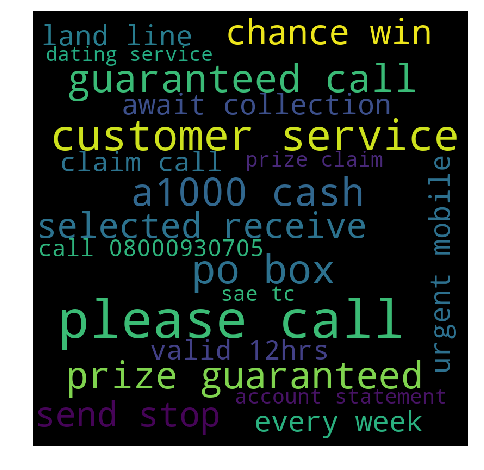

In [20]:
data = {k[0] + ' ' + k[1]:v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(height=800, width=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')

### Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [21]:
top_20_spam_trigrams = pd.Series(nltk.ngrams(spam_string.split(), 3)).value_counts().head(20)
top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
dtype: int64

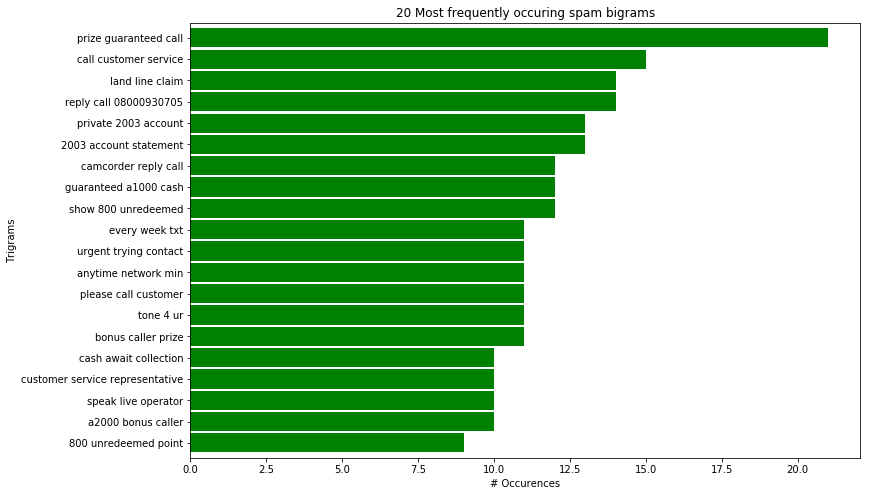

In [22]:
top_20_spam_trigrams.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring spam bigrams')
plt.xlabel('# Occurences')
plt.ylabel('Trigrams')

ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.\
    reset_index().\
    sort_values(by=0)['index'].\
    apply(lambda x: x[0] + ' ' + x[1] + ' ' + x[2])
plt.yticks(ticks, labels)
plt.show()

(-0.5, 499.5, 499.5, -0.5)

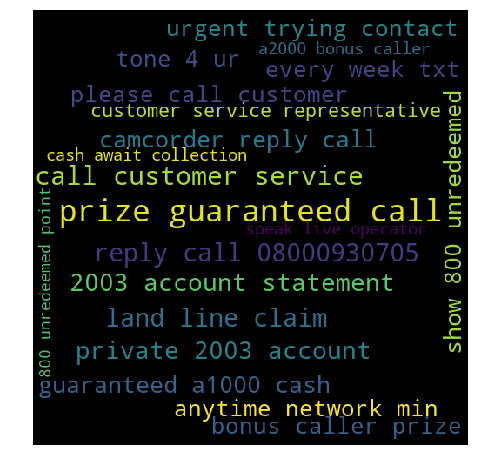

In [23]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]:v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(height=500, width=500).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')

In [24]:
top_20_ham_trigrams = pd.Series(nltk.ngrams(ham_string.split(), 3)).value_counts().head(20)
top_20_ham_trigrams.head()

(i'll, call, later)     41
(sorry, i'll, call)     38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
dtype: int64

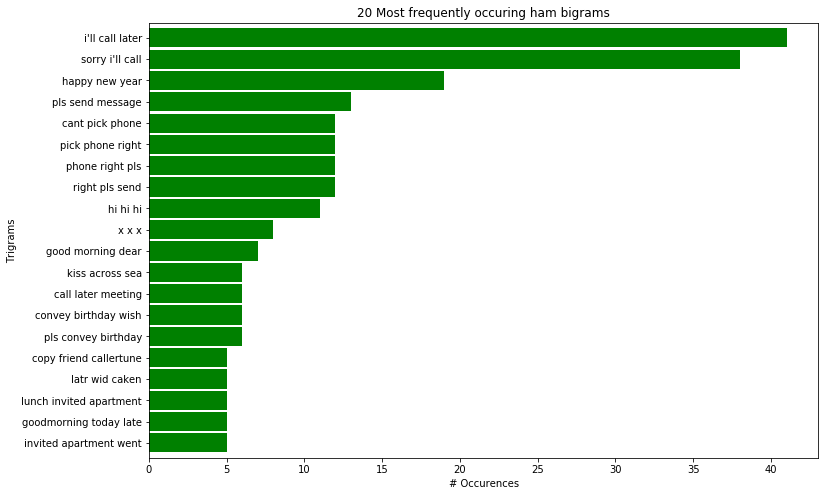

In [25]:
top_20_ham_trigrams.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring ham bigrams')
plt.xlabel('# Occurences')
plt.ylabel('Trigrams')

ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.\
    reset_index().\
    sort_values(by=0)['index'].\
    apply(lambda x: x[0] + ' ' + x[1] + ' ' + x[2])
plt.yticks(ticks, labels)
plt.show()

(-0.5, 799.5, 799.5, -0.5)

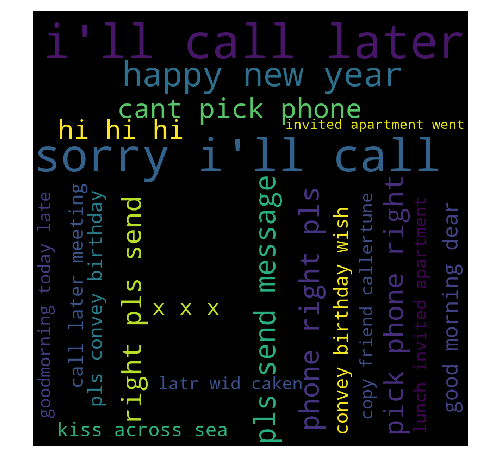

In [26]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]:v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(height=800, width=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')

## Explore the blog articles using the techniques discussed in the exploration lesson.

In [27]:
list_of_blogs = acquire.get_blog_articles()
list_of_news = acquire.get_news_articles()

In [28]:
prepped_blogs = prepare.prepare_article_data(list_of_blogs)
prepped_news = prepare.prepare_article_data(list_of_news)

In [29]:
blogs = pd.DataFrame(prepped_blogs)[['title', 'original', 'clean', 'lemmatized']]
blogs.head()

,title,original,clean,lemmatized
0,codeups_data_science_career_accelerator_is_here,\nThe rumors are true! The time has arrived. C...,rumors true time arrived codeup officially ope...,rumor true time arrived codeup officially open...
1,data_science_myths,\nBy Dimitri Antoniou and Maggie Giust\nData S...,dimitri antoniou maggie giust data science big...,dimitri antoniou maggie giust data science big...
2,data_science_vs_data_analytics_whats_the_diffe...,"\nBy Dimitri Antoniou\nA week ago, Codeup laun...",dimitri antoniou week ago codeup launched imme...,dimitri antoniou week ago codeup launched imme...
3,10_tips_to_crush_it_at_the_sa_tech_job_fair,\n10 Tips to Crush It at the SA Tech Job Fair\...,10 tips crush sa tech job fair sa tech job fai...,10 tip crush sa tech job fair sa tech job fair...
4,competitor_bootcamps_are_closing_is_the_model_...,\nCompetitor Bootcamps Are Closing. Is the Mod...,competitor bootcamps closing model danger prog...,competitor bootcamps closing model danger prog...


In [30]:
news = pd.DataFrame(prepped_news)[['category', 'title', 'original', 'clean', 'lemmatized']]
news.head()

,category,title,original,clean,lemmatized
0,Business,4th richest man Buffett says Tesla can't sell ...,After world's fourth-richest person Warren Buf...,world's fourthrichest person warren buffett cl...,world's fourthrichest person warren buffett cl...
1,Business,"Guj trader, who gifted cars to staff, to remov...","Gujarat-based diamond trader Savji Dholakia, w...",gujaratbased diamond trader savji dholakia who...,gujaratbased diamond trader savji dholakia who...
2,Business,"Infosys makes Hyd staff pay for parking, activ...",Activists in Hyderabad have claimed that Infos...,activists hyderabad claimed infosys deducting ...,activist hyderabad claimed infosys deducting p...
3,Business,"AI sent ₹2cr to Nigeria instead of US firm, ai...","Air India's New York office transferred $300,0...",air india's new york office transferred 300000...,air india's new york office transferred 300000...
4,Business,We can't ensure cheaper oil sales to India aft...,US Commerce Secretary Wilbur Ross on Monday sa...,us commerce secretary wilbur ross monday said ...,u commerce secretary wilbur ross monday said c...
